# Spatial random forest for flood prediction
Outcome variable: `flood` represents presence/absence of flood in pixel (slightly misleading name.)


Slightly dodgy, but modified this file to get rid of the annoying ImportError: Numba needs NumPy 1.21 or less. <br> _'~/miniconda3/envs/hybridmodels-modelbuild/lib/python3.10/site-packages/numba/__init__.py'_ <br>
changed line 139 from ```elif numpy_version > (1, 21):``` to ```elif numpy_version > (1, 23):```
Seems okay so far...

In [45]:
RUNNAME = ''  # leave blank for run not being saved

In [46]:
# general imports
from os.path import join
from os import mkdir
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import logging
from datetime import datetime

# machine learning imports
from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix as cm
from sklearn.inspection import permutation_importance

# plotting imports
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.ticker import FuncFormatter

# helper function imports
from importlib import reload
import model_utils
import data_utils
import viz_utils
from viz_utils import soge_colours

# fix for local issue with multiple proj installations
import pyproj
pyproj.datadir.get_data_dir()  # '/Users/alison/miniconda3/share/proj'
pyproj.datadir.set_data_dir('/Users/alison/miniconda3/envs/hybridmodels-modelbuild/share/proj')
pyproj.datadir.get_data_dir()

# ignore annoying FutureWarning in RandomForest cell
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# set up the environment
wd = join("..", "data")
imdir = join(wd, 'images')
logdir = join("logfiles")

# create logging to file
logger = logging.getLogger("rf_spatial")
logger.setLevel(logging.INFO)
fh = logging.FileHandler(join(logdir, "rf_spatial.log"), mode='a')
fh.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s, %(levelname)s: %(message)s')
fh.setFormatter(formatter)
logger.addHandler(fh)

# folder for image results of this run
runtime = datetime.now()
try:
    mkdir(join(imdir, 'rf_spatial', RUNNAME))
except Exception as e:
    print(e)
    
    
def add_feature_label(feature):
    if '_spatial' in feature:
        string = feature.replace('_spatial', '')
        string = viz_utils.labels[string]
        string = ' '.join([string, 'spatial']) 
    elif '_to_pw' in feature:
        string = feature.replace('_to_pw', '')
        string = viz_utils.labels[string]
        string = ' '.join([string, 'to pw']) 
    else:
        string = viz_utils.labels[feature]
    return string

# settings
viz = True
storm = "gombe"  # e.g., "roanu" or "" for all events
temporal = False
binary = True
floodthresh = 0.5

test_events = ['gombe_mossuril_1', 'roanu_chittagong_2', 'irma_tampanorth_1']
logthisrun = True

[Errno 17] File exists: '../data/images/rf_spatial/'


## Load  data and visualisa

In [47]:
reload(model_utils)
gdf = model_utils.load_spatial_data(wd)

In [48]:
# subset by a continent (can change to ocean)
subset = False
if subset:
    datasets = pd.read_csv(join(wd, 'csvs', 'current_datasets.csv'))[['event', 'region', 'continent']]
    datasets = datasets[datasets['continent'] == 'africa']
    events_list = [*datasets[['event', 'region']].agg('_'.join, axis=1)]

    gdf['event_region'] = gdf['event'].apply(lambda x: '_'.join(x.split('_')[:-1]))
    gdf = gdf[gdf['event_region'].isin(events_list)]
    gdf = gdf.drop('event_region', axis=1)

In [49]:
gdf['event'].unique()

array(['irma_tampasouth_0', 'irma_jacksonvillesouth_0',
       'gombe_mossuril_5', 'ian_cuba_9', 'ian_cuba_16',
       'nakri_vietnam_1_0', 'batsirai_menabe_0', 'nakri_vietnam_3_0',
       'batsirai_menabe_1', 'ian_cuba_4', 'noul_vietnam_0',
       'batsirai_mananjary_0', 'goni_tiwi_0', 'roanu_satkania_0',
       'ian_cuba_8', 'gombe_mossuril_4', 'irma_jacksonvillesouth_1',
       'irma_tampasouth_1', 'batsirai_tsiribihina_0', 'goni_bato_0',
       'roanu_chittagong_0', 'nakri_tuyhoa_0', 'ian_cuba_3',
       'fani_eastindia_0_0', 'roanu_barguna_0', 'gombe_mossuril_3',
       'roanu_lalmohan_0', 'ian_cuba_10', 'roanu_lalmohan_1',
       'ian_cuba_11', 'megi_westernvisayas_0', 'roanu_barguna_1',
       'ian_cuba_2', 'roanu_chittagong_1', 'ian_cuba_1',
       'irma_tampanorth_0', 'roanu_chittagong_2', 'nakri_vietnam_0_0',
       'megi_westernvisayas_3', 'ian_cuba_12', 'rai_hinunangan_0',
       'roanu_lalmohan_2', 'gombe_mossuril_1', 'roanu_coxsbazar_1',
       'roanu_barguna_2', 'roanu_c

In [50]:
data_utils.default_features

['elevation',
 'jrc_permwa',
 'slope_pw',
 'dist_pw',
 'precip',
 'soilcarbon',
 'mangrove',
 'ndvi',
 'aqueduct',
 'lulc',
 'deltares',
 'soiltemp1',
 'soiltemp2',
 'exclusion_mask']

In [51]:
gdf_to_plot.event

0            gombe_mossuril_5
1            gombe_mossuril_5
2            gombe_mossuril_5
3            gombe_mossuril_5
4            gombe_mossuril_5
                ...          
2634    emnati_madagascar_0_0
2635    emnati_madagascar_0_0
2636    emnati_madagascar_0_0
2637    emnati_madagascar_0_0
2638    emnati_madagascar_0_0
Name: event, Length: 17329, dtype: object

In [56]:
gdf_to_plot.event.unique()

array(['irma_tampasouth_0', 'irma_jacksonvillesouth_0',
       'gombe_mossuril_5', 'ian_cuba_9', 'ian_cuba_16',
       'nakri_vietnam_1_0', 'batsirai_menabe_0', 'nakri_vietnam_3_0',
       'batsirai_menabe_1', 'ian_cuba_4', 'noul_vietnam_0',
       'batsirai_mananjary_0', 'goni_tiwi_0', 'roanu_satkania_0',
       'ian_cuba_8', 'gombe_mossuril_4', 'irma_jacksonvillesouth_1',
       'irma_tampasouth_1', 'batsirai_tsiribihina_0', 'goni_bato_0',
       'roanu_chittagong_0', 'nakri_tuyhoa_0', 'ian_cuba_3',
       'fani_eastindia_0_0', 'roanu_barguna_0', 'gombe_mossuril_3',
       'roanu_lalmohan_0', 'ian_cuba_10', 'roanu_lalmohan_1',
       'ian_cuba_11', 'megi_westernvisayas_0', 'roanu_barguna_1',
       'ian_cuba_2', 'roanu_chittagong_1', 'ian_cuba_1',
       'irma_tampanorth_0', 'roanu_chittagong_2', 'nakri_vietnam_0_0',
       'megi_westernvisayas_3', 'ian_cuba_12', 'rai_hinunangan_0',
       'roanu_lalmohan_2', 'gombe_mossuril_1', 'roanu_coxsbazar_1',
       'roanu_barguna_2', 'roanu_c

In [53]:
test_events

['gombe_mossuril_1', 'roanu_chittagong_2', 'irma_tampanorth_1']

/var/folders/7w/k72v6f5x25gblsqmh6bxd3j40000gn/T/ipykernel_1486/544206592.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_to_plot = gdf.set_geometry(gdf.centroid)


TypeError: no numeric data to plot

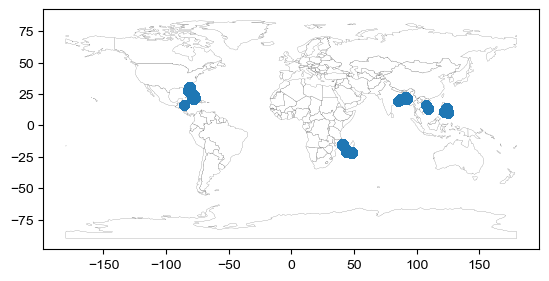

In [52]:
# plot here
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(color='white', edgecolor='black', linewidth=0.1)

gdf_to_plot = gdf.set_geometry(gdf.centroid)
gdf_test_to_plot = gdf_to_plot.event.isin(test_events)

gdf_to_plot.plot(ax=ax)
gdf_test_to_plot.plot(ax=ax, color='red')

0       False
1       False
2       False
3       False
4       False
        ...  
2634    False
2635    False
2636    False
2637    False
2638    False
Name: event, Length: 17329, dtype: bool

In [33]:
datasets = pd.read_csv(join(wd, 'csvs', 'current_datasets.csv'))


# for each event <storm>_<region> find the corresponding source [WorldFloods, EMS, GFM] or satellite or whatever
# also take out test set and plot as red

In [34]:
datasets

,event,country,region,ocean,continent,nsubregions,start_date,end_date,source,sensor,landfall_time,acquisition_time,to_process,comments,subregion_geojsons
0,gombe,mozambique,mossuril,indian,africa,6,2022-03-07,2022-03-17,Copernicus EMS,TerraSAR-X,2022-03-11 00:00,2022-03-17 02:51,no,NaN,"{\n ""type"": ""FeatureCollection"",\n ""features..."
1,batsirai,madagascar,tsiribihina,indian,africa,1,2022-01-27,2022-02-08,Copernicus EMS,Radarsat-2,2022-02-05 15:00,2022-02-06 02:24,no,missing lower-left corner,"{\n ""type"": ""FeatureCollection"",\n ""features..."
2,batsirai,madagascar,mananjary,indian,africa,1,2022-01-27,2022-02-08,Copernicus EMS,TerraSAR-X,2022-02-05 15:00,2022-02-06 03:01,no,NaN,"{\n ""type"": ""FeatureCollection"",\n ""features..."
3,batsirai,madagascar,menabe,indian,africa,2,2022-01-27,2022-02-08,Copernicus GFM,Sentinel-1,2022-02-05 15:00,2022-02-06 02:36,no,NaN,"{\n""type"": ""FeatureCollection"",\n""name"": ""subr..."
4,rai,philippines,hinunangan,pacific,asia,1,2021-12-13,2021-12-21,Copernicus EMS,Sentinel-1,2021-12-16 09:00,2021-12-19 21:31,no,NaN,"{\n ""type"": ""FeatureCollection"",\n ""features..."
5,iota,honduras,loweraguanbasin,pacific,north america,1,2020-11-12,2020-11-18,Copernicus EMS,Cosmo-SkyMed,2020-11-17 03:00,22/11/2020 11:44,no,NaN,"{\n ""type"": ""FeatureCollection"",\n ""features..."
6,goni,philippines,tiwi,pacific,asia,1,2020-10-25,2020-11-06,Copernicus EMS,Pleiades,2020-10-31 21:00,08/11/2020 02:36,no,"width < 2 km, don't include in analysis","{\n ""type"": ""FeatureCollection"",\n ""name"": ""..."
7,goni,philippines,virac,pacific,asia,1,2020-10-25,2020-11-06,Copernicus EMS,Pleiades,2020-10-31 21:00,08/11/2020 02:35,no,"width < 2 km, don't include in analysis","{\n ""type"": ""FeatureCollection"",\n ""name"": ""..."
8,goni,philippines,bato,pacific,asia,1,2020-10-25,2020-11-06,Copernicus EMS,Pleiades,2020-10-31 21:00,06/11/2020 02:02,no,"width < 2 km, don't include in analysis","{\n ""type"": ""FeatureCollection"",\n ""name"": ""..."
9,molave,vietnam,hue,pacific,asia,1,2020-10-21,2020-10-29,Copernicus EMS,Cosmo-SkyMed,2020-10-28 03:00,2020-10-28 22:46,never,Flood file does not intersect subregion,"{\n ""type"": ""FeatureCollection"",\n ""features..."


In [32]:
gdf

,floodfrac,slope_pw,soilcarbon,jrc_permwa,mangrove,elevation,aqueduct,wind_avg,deltares,event,...,geometry,exclusion_mask,built_up,bare_soil,vegetated,water,built_up_spatial,bare_soil_spatial,vegetated_spatial,water_spatial
0,0,0.000771,5.485714,0.008264,0.0,15.151755,0,6.564846,0,gombe_mossuril_5,...,"POLYGON ((40.43977 -15.24127, 40.44426 -15.241...",0.0,0,0,1,0,0,0,1,0
1,0,0.000867,5.475610,0.004132,0.0,16.757664,0,6.526891,0,gombe_mossuril_5,...,"POLYGON ((40.43977 -15.24561, 40.44426 -15.245...",0.0,0,0,1,0,0,0,1,0
2,0,0.001067,5.212245,0.000000,0.0,20.283682,0,6.493143,0,gombe_mossuril_5,...,"POLYGON ((40.43977 -15.24994, 40.44426 -15.249...",0.0,0,0,1,0,0,0,1,0
3,0,0.001188,4.196721,0.000000,0.0,22.200342,0,6.464360,0,gombe_mossuril_5,...,"POLYGON ((40.43977 -15.25427, 40.44426 -15.254...",0.0,0,0,1,0,0,0,1,0
4,0,0.001201,5.489796,0.000000,0.0,22.079014,0,6.441091,0,gombe_mossuril_5,...,"POLYGON ((40.43977 -15.25861, 40.44426 -15.258...",0.0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2634,1,0.006005,3.272340,7.674419,0.0,5.878428,0,6.333499,0,emnati_madagascar_0_0,...,"POLYGON ((48.03147 -22.08842, 48.03596 -22.088...",0.0,0,0,1,0,0,0,1,0
2635,1,0.009624,3.389831,0.130081,0.0,7.273581,0,6.332122,0,emnati_madagascar_0_0,...,"POLYGON ((48.03147 -22.09258, 48.03596 -22.092...",0.0,0,0,1,0,0,0,1,0
2636,0,0.016264,3.182203,0.000000,0.0,8.862112,0,6.330745,0,emnati_madagascar_0_0,...,"POLYGON ((48.03147 -22.09674, 48.03596 -22.096...",0.0,0,0,1,0,0,0,1,0
2637,0,0.024010,3.178723,0.039823,0.0,7.789804,0,6.329367,0,emnati_madagascar_0_0,...,"POLYGON ((48.03147 -22.10090, 48.03596 -22.100...",0.0,0,0,1,0,0,0,1,1


## Process data

In [7]:
"""
Process features for machine learning - order of functions matters here.

Add the functions to model_utils.py later
"""

reload(model_utils)
SEED = 1
print(f"Initial length of dataframe: {len(gdf)}")

# remove features
def remove_feature(to_remove, columns, notes):
    if "transforms" not in gdf.attrs:
        gdf.attrs['transforms'] = {}
        
    for feature in to_remove:
        columns.remove(feature)
        notes.append(f'{feature} excluded')
        gdf.attrs['transforms'][feature] = ['removed']
    return columns, notes


# NEW: summarise LULC data
def summarise_lulc(gdf, columns, features_binary, features_continuous, notes):
    """Summarise LULC into four categories."""
        
    # set up lulc dict
    lulc_summary = {value: key for key, values in model_utils.lulc_categories.items() for value in values}
    lulc_summary_spatial = {f'{key}_spatial': f'{value}_spatial' for key, value in lulc_summary.items()}
    lulc_summary = lulc_summary | lulc_summary_spatial
    
    # change gdf
    lulc_cols = [key for key in model_utils.lulc_categories.keys()]
    lulc_cols += [f'{key}_spatial' for key in lulc_cols]
    gdf = gdf.rename(columns=lulc_summary)
    gdf_lulc = gdf[lulc_cols].groupby(level=0, axis=1).any().astype(float)
    gdf = gdf.drop(columns=lulc_cols)# .join(gdf_lulc)
    gdf[lulc_cols] = gdf_lulc[lulc_cols]
    
    # change corresponding variables
    columns = [*set(lulc_summary[x] if x in lulc_summary.keys() else x for x in columns)]
    features_binary = [*set(lulc_summary[x] if x in lulc_summary.keys() else x for x in features_binary)]
    features_continuous = [*set(lulc_summary[x] if x in lulc_summary.keys() else x for x in features_continuous)]
    nfeatures = len(features_binary) + len(features_continuous)
    
    # make note of changes
    if "transforms" not in gdf.attrs:
        gdf.attrs['transforms'] = {}
    if 'lulc' not in gdf.attrs['transforms']:
        gdf.attrs['transforms']['lulc'] = []
    gdf.attrs['transforms']['lulc'].append('summarised into three categories')
    notes.append('summarised lulc columns into three categories')
    
    return gdf, columns, features_binary, features_continuous, nfeatures, notes

# random undersampling
def random_undersample(gdf, notes, columns, SEED):
    
    gdf_flood = gdf[gdf.floodfrac==1]
    gdf_noflood = gdf[gdf.floodfrac==0]
    gdf_noflood = gdf_noflood.sample(n=n1, random_state=SEED)
    gdf_undersampled = pd.concat([gdf_flood, gdf_noflood])
    gdf_undersampled = gdf_undersampled[columns]
    
    # make note of changes
    if "transforms" not in gdf.attrs:
        gdf.attrs['transforms'] = {}
    gdf_undersampled.attrs = gdf.attrs
    if 'general' not in gdf_undersampled.attrs['transforms']:
        gdf_undersampled.attrs['transforms']['general'] = []
    gdf_undersampled.attrs['transforms']['general'].append('undersampled to same number of flood and non-flood.')
    notes.append('undersampled to same number of flood and non-flood pixels')
    
    return gdf_undersampled, notes
                 

# columns
notes = []
columns = [*gdf.columns]
to_remove = ['lulc__40', 'lulc__40_spatial']
columns, notes = remove_feature(to_remove, columns, notes)
                 
# feature columns             
features = columns.copy()
features.remove('geometry')
features.remove('floodfrac')
features.remove('event')
nfeatures = len(features)

# sort binary and continuous features
features_binary, features_continuous = data_utils.split_features_binary_continuous(data_utils.binary_keywords, features)

# NEW: summarise LULC columns
gdf, columns, features_binary, features_continuous, nfeatures, notes = summarise_lulc(gdf, columns, features_binary, features_continuous, notes)
features = features_binary + features_continuous
print(f"After summarising LULC length: {len(gdf)}")

# binarise binary features
thresh = floodthresh
for feature in features_binary:
    gdf[feature] = gdf[feature].apply(lambda x: 1 if x > thresh else 0).astype(int)

# remove permanent water cells
gdf = gdf[gdf['dist_pw'] > 0]
notes.append('removed permanent water grid cells')

# remove exclusion mask cells
gdf.loc[:, 'exclusion_mask'] = gdf['exclusion_mask'].apply(lambda x: 0 if np.isnan(x) else x)
gdf = gdf[gdf['exclusion_mask'] != 1]
notes.append('removed exclusion mask cells')

# normalise continuous features
gdf_normalised = gdf.copy(deep=True)
for feature in features_continuous:
    gdf_normalised = model_utils.normalise_feature(gdf_normalised, feature)
print(f"After normalisation length: {len(gdf_normalised)}")
# check what's been normalised: gdf_normalised.attrs

# remove test event from data for testing and plotting later
gdf_test_unseen = gdf_normalised[gdf_normalised['event'].apply(lambda x: x in test_events)]
gdf_normalised = gdf_normalised[~(gdf_normalised['event'].apply(lambda x: x in test_events))]
gdf_test_unseen = gpd.overlay(gdf_test_unseen, gdf_normalised, how='difference')  # remove any overlapping bits

# random undersampling
global n, n1, n0
n = len(gdf)
n1 = gdf['floodfrac'].sum()
n0 = n - n1
gdf_normalised, notes = random_undersample(gdf_normalised, notes, columns, SEED)

gdf_normalised = gdf_normalised.replace(np.nan, 0.)
gdf_normalised['floodfrac'] = gdf_normalised['floodfrac'].astype(int)

print(f"After undersampling length: {len(gdf_normalised)}")
print(f"Number of ones: {gdf_normalised['floodfrac'].sum()}")
print(f"Number of zeros: {gdf_normalised['floodfrac'].count() - gdf_normalised['floodfrac'].sum()}")

print(f"\nNotes:\n\n{notes}")

Initial length of dataframe: 36864
After summarising LULC length: 36864
After normalisation length: 17329
After undersampling length: 4454
Number of ones: 2102
Number of zeros: 2352

Notes:

['lulc__40 excluded', 'lulc__40_spatial excluded', 'summarised lulc columns into three categories', 'removed permanent water grid cells', 'removed exclusion mask cells', 'undersampled to same number of flood and non-flood pixels']


/Users/alison/miniconda3/envs/hybridmodels-modelbuild/lib/python3.10/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/Users/alison/miniconda3/envs/hybridmodels-modelbuild/lib/python3.10/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


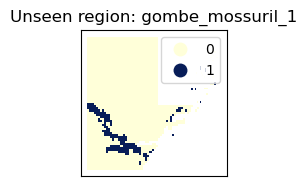

In [8]:
fig, ax = plt.subplots(1, len(test_events))

for i, event in enumerate(test_events):
    to_plot = gdf_test_unseen[gdf_test_unseen.event == event]   
    to_plot.plot('floodfrac', cmap="YlGnBu", ax=ax[i], legend=True)
    ax[i].set_title(f'Unseen region: {event}')
    
    ax[i].set_xticks([])
    ax[i].set_yticks([])

# Random Forest: model
## Cross-validate results with the tuned hyperparameters

In [9]:
from tqdm.notebook import tqdm

run_rf = True

if run_rf:
    K = 5  # number of folds to use
    best_params = np.load('best_params_rf.npy', allow_pickle=True).item()

    X, y = gdf_normalised[features + ['event', 'geometry']], gdf_normalised['floodfrac']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=SEED)
    
    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    
    # separate from data for plotting later
    X_train_toview = X_train.copy(deep=True)
    X_test_seen = X_test.copy(deep=True)
    
    X_train = X_train[features]
    X_test = X_test[features]

    cv = KFold(n_splits=K, random_state=SEED, shuffle=True)

    CSIs = []
    TPs = []
    FPs = []
    TNs = []
    FNs = []
    rankings = []

    for train_index, val_index in tqdm(cv.split(X_train)):
        Xf_train, Xf_test = X_train.iloc[train_index, :], X_train.iloc[val_index, :]
        yf_train, yf_test = y_train[train_index], y_train[val_index]

        rf = RandomForestClassifier(random_state=SEED, **best_params)
        rf.fit(Xf_train, yf_train)
        yf_pred = rf.predict(Xf_test)  # sample_weight=None

        confusion_matrix = cm(yf_test, yf_pred)

        if confusion_matrix.shape == (2, 2):
            TP = confusion_matrix[1, 1]
            FP = confusion_matrix[0, 1] #(row, col) = (true, pred)
            FN = confusion_matrix[1, 0]
            TN = confusion_matrix[0, 0]

            TPs.append(TP)
            FPs.append(FP)
            FNs.append(FN)
            TNs.append(TN)

            CSI = TP / (TP + FP + FN)  # critical success index
            CSIs.append(CSI)

        rankings.append(pd.Series(rf.feature_importances_, index=features))

0it [00:00, ?it/s]

In [10]:
print(f"mean of training CSIs: {np.mean(CSIs):.02%}")
print(f"std. of training CSIs: {np.std(CSIs):.02%}")

mean of training CSIs: 80.73%
std. of training CSIs: 1.41%


## Evaluate on test set in seen location

In [11]:
from matplotlib.colors import ListedColormap
from viz_utils import soge_colours


def get_csi(y_test, y_pred):
    """Return CSI and relevant metrics for two arrays."""
    confusion_matrix = cm(y_test, y_pred)
    if confusion_matrix.shape == (2, 2):
        TP = confusion_matrix[1, 1]
        FP = confusion_matrix[0, 1]  # (row, col) = (true, pred)
        FN = confusion_matrix[1, 0]
        TN = confusion_matrix[0, 0]
        CSI = TP / (TP + FP + FN)    # CSI / IoU / Jaccard Index
        
        return CSI, TP, FP, FN, TN


def confusion_label(y_test, y_pred):
    """Assign confusion label to a (true, predicted) pair."""
    if y_pred + y_test == 2:
        return 'TP'
    elif y_pred + y_test == 0:
        return 'TN'
    elif (y_test == 0) and (y_pred == 1):
        return 'FP'
    elif (y_test == 1) and (y_pred == 0):
        return 'FN'
    else:
        print(f"ISSUE: {y_test}, {y_pred}")
        return ''

In [12]:
# train the model on the full test set
rf.fit(X_train, y_train)

# predictions for the test set
y_pred = rf.predict(X_test)
CSI_test_seen, _, _, _, _ = get_csi(y_test, y_pred)
print(f"CSI for seen test region: {CSI_test_seen:.02%}")

CSI for seen test region: 81.55%


/var/folders/7w/k72v6f5x25gblsqmh6bxd3j40000gn/T/ipykernel_1486/1127511580.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  X_test_event = X_test_event.set_geometry(X_test_event.centroid)
/var/folders/7w/k72v6f5x25gblsqmh6bxd3j40000gn/T/ipykernel_1486/1127511580.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  X_test_event = X_test_event.set_geometry(X_test_event.centroid)
/var/folders/7w/k72v6f5x25gblsqmh6bxd3j40000gn/T/ipykernel_1486/1127511580.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  X_test_event = X_test_event.set_geometry(X_test_event.centroid)
/

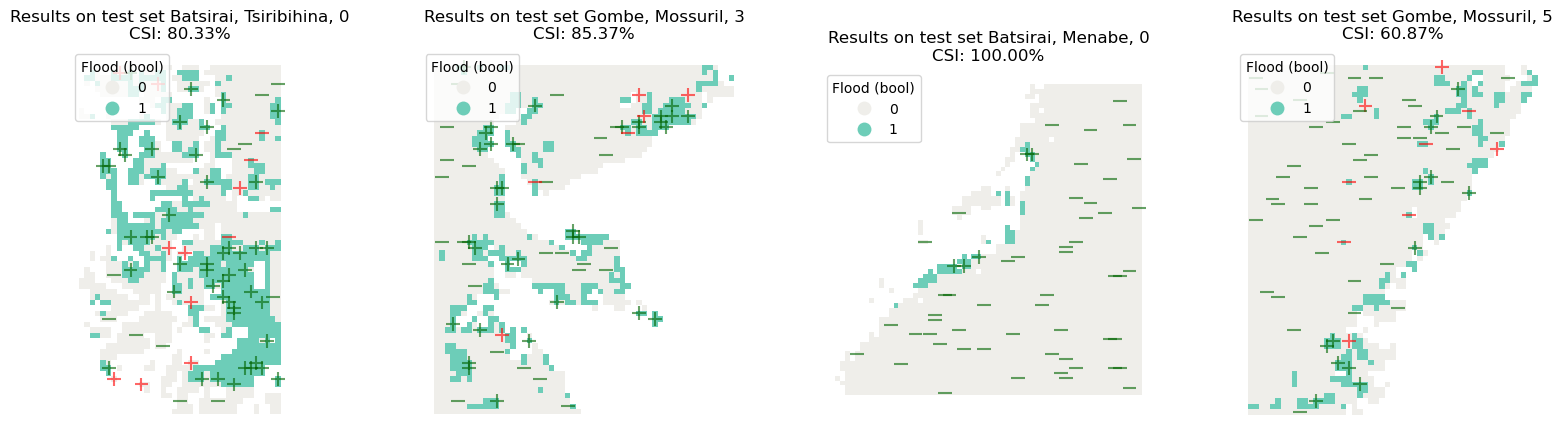

In [14]:
# process data to view single event
X_test_seen[f'flood_true'] = y_test
X_test_seen[f'flood_pred'] = y_pred
X_test_seen['confusion'] = X_test_seen[[f'flood_true', f'flood_pred']].apply(lambda row: confusion_label(row[f'flood_true'], row[f'flood_pred']), axis=1)
events = X_test_seen['event'].unique()

# loop through events
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for i, event_to_view in enumerate(events[[1, 2, 5, 4]]):  # choose what you want to view
    
    # subset event and calculate csi
    X_test_event = X_test_seen[X_test_seen['event'] == event_to_view]
    X_test_event = X_test_event.set_geometry(X_test_event.centroid)
    csi_test_seen, _, _, _, _ = get_csi(X_test_event[f'flood_true'], X_test_event[f'flood_pred'])

    # set up colors and markerstyles
    bg_cmap = ListedColormap([soge_colours['beige'], soge_colours['light turquoise']])
    markerstyles = {'TP': '+', 'FP': '+', 'TN': '_', 'FN': '_'}
    markercolors = {'TP': 'darkgreen', 'FP': 'red', 'TN': 'darkgreen', 'FN': 'red'}
    X_test_pos = X_test_event[X_test_event.confusion.isin(['TP', 'FP'])]
    X_test_neg = X_test_event[X_test_event.confusion.isin(['TN', 'FN'])]
    bg = gdf[gdf['event'] == event_to_view]

    # plot background and test set points
    bg.plot('floodfrac', categorical=True, cmap=bg_cmap, ax=axs[i], legend=True,
            legend_kwds={'title': 'Flood (bool)', 'loc': 'upper left'})

    X_test_pos.plot(color=X_test_pos['confusion'].map(markercolors), alpha=0.6,
                    marker='+',  markersize=100, ax=axs[i], categorical=True)

    X_test_neg.plot(color=X_test_neg['confusion'].map(markercolors), alpha=0.6,
                      marker='_',  markersize=100, ax=axs[i], categorical=True)
    
    axs[i].set_title(f"Results on test set {', '.join([x.capitalize() for x in event_to_view.split('_')])}\nCSI: {csi_test_seen:.2%}")
    

for ax in axs:
    # clean up axses
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

fig.savefig(join(imdir, 'rf_spatial', 'test_set_results.png'), dpi=500, bbox_inches='tight')
fig.savefig(join(imdir, 'rf_spatial', RUNNAME, 'test_set_results.png'), dpi=500, bbox_inches='tight')

## Feature rankings
1. Impurity-based importance
2. [Permutation-based importances](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html#sklearn.inspection.permutation_importance)

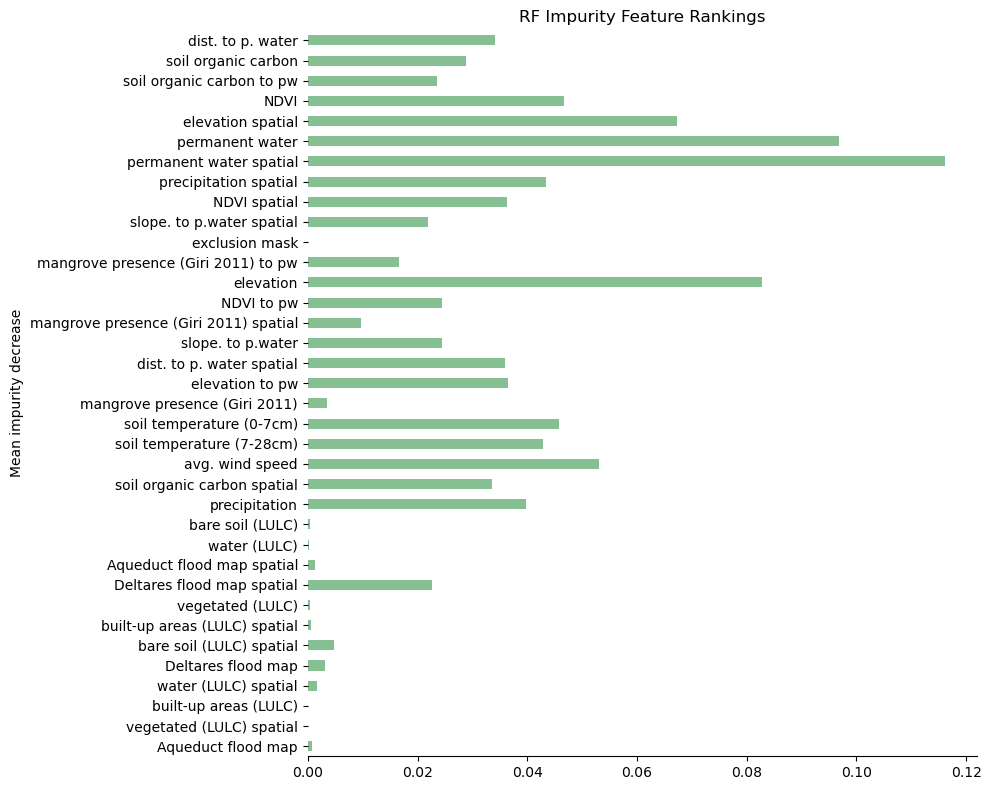

In [15]:
# impurity-based importances
reload(viz_utils)
runme = True
savefig = True

if runme:
    stds = [np.std([rank[feature] for rank in rankings]) for feature in features]
    means = [np.mean([rank[feature] for rank in rankings]) for feature in features]

    mean_rankings = pd.Series(means, index=features)
    mean_rankings = mean_rankings.rename(index=add_feature_label)

    fig, ax = plt.subplots(figsize=(10, 8))
    mean_rankings.plot.barh(yerr=stds, ax=ax, color='#86bf91')
    ax.set_title("RF Impurity Feature Rankings")
    ax.set_ylabel("Mean impurity decrease")
    fig.tight_layout()

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    if savefig:
        fig.savefig(join(imdir, "rf_spatial", f"RF impurity feature rankings temporal{temporal}"), dpi=500)
        fig.savefig(join(imdir, "rf_spatial", RUNNAME, f"RF impurity feature rankings temporal{temporal}"), dpi=500)

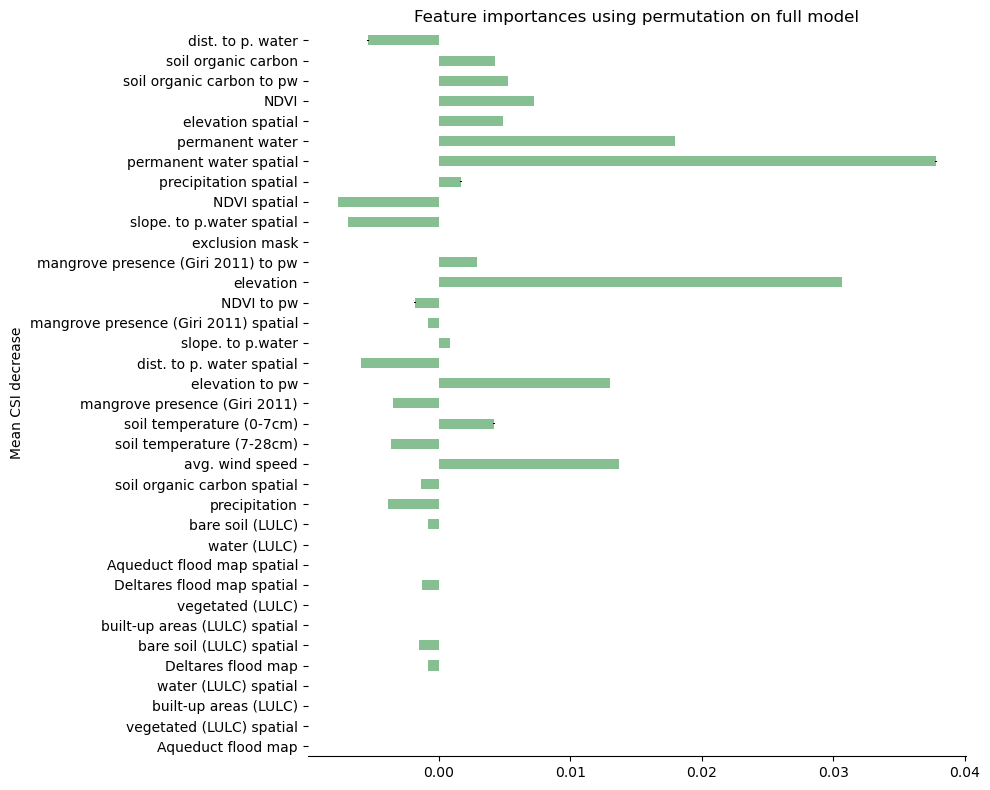

In [16]:
# permutatation importances
run_pis = True

# use critical success index to evaluate model according to scorer
def csi(y_true, y_pred):
    """Critical success index"""
    confusion_matrix = cm(y_true, y_pred)
    TP = confusion_matrix[1, 1]
    FP = confusion_matrix[0, 1]  # (row, col) = (true, pred)
    FN = confusion_matrix[1, 0]
    csi = TP / (TP + FP + FN)  # critical success index
    return csi

def evaluate(model, test_features, test_labels):
    test_predictions = model.predict(test_features)
    csi_val = csi(test_labels, test_predictions)
    print('Model Performance')
    print('CSI = {:0.2f}%.'.format(csi_val))  # should * 100 for next run
    
    
    return csi_val

csi_scorer = make_scorer(csi)

if run_pis:
    savefig = True

    best_params = np.load('best_params_rf.npy', allow_pickle=True).item()
    pi = permutation_importance(rf, X_test, y_test, scoring=csi_scorer, random_state=SEED)
    mean_pis = pd.Series(pi.importances_mean, index=features)
    mean_pis = mean_pis.rename(index=add_feature_label)


    fig, ax = plt.subplots(figsize=(10, 8))
    mean_pis.plot.barh(yerr=pi.importances_std, ax=ax, color='#86bf91')
    ax.set_title("Feature importances using permutation on full model")
    ax.set_ylabel("Mean CSI decrease")
    fig.tight_layout()

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    if savefig:
        fig.savefig(join(imdir, "rf_spatial", f"RF permutation feature rankings temporal{temporal}"), dpi=500)
        fig.savefig(join(imdir, "rf_spatial", RUNNAME, f"RF permutation feature rankings temporal{temporal}"), dpi=500)

# Evaluate on an unseen subregion

In [17]:
gdf_test_unseen.loc[:, 'exclusion_mask'] = gdf_test_unseen.loc[:, 'exclusion_mask'].apply(lambda x: 0.0 if np.isnan(x) else x)

In [18]:
# view predictions on the test event
def get_csi(y_test_event, y_pred_event):
    confusion_matrix = cm(y_test_event, y_pred_event)

    TP_test = confusion_matrix[1, 1]
    FP_test = confusion_matrix[0, 1]
    FN_test = confusion_matrix[1, 0]
    TN_test = confusion_matrix[0, 0]

    CSI_test_unseen = TP_test / (TP_test + FP_test + FN_test)  # critical success index
    
    return CSI_test_unseen


plt.rcParams['font.family'] = 'Arial'
gdf_test_unseen['floodfrac'] = gdf_test_unseen['floodfrac'].astype(int)
X_test_event, y_test_event = gdf_test_unseen[features], gdf_test_unseen['floodfrac']
y_pred_event = rf.predict(X_test_event)
CSI_test_unseen = get_csi(y_test_event, y_pred_event)

In [19]:
y_true_event = gdf_test_unseen['floodfrac'].to_numpy()
gdf_test_unseen['flood_pred'] = y_pred_event
gdf_test_unseen['error_type'] = gdf_test_unseen[['floodfrac', 'flood_pred']].apply(lambda row: confusion_label(row[0], row[1]), axis=1)

# make flood categorical for plotting
gdf_test_unseen['floodfrac'] = gdf_test_unseen['floodfrac'].apply(lambda x: 'No flood' if x==0 else 'Flood')
gdf_test_unseen['flood_pred'] = gdf_test_unseen['flood_pred'].apply(lambda x: 'No flood' if x==0 else 'Flood')

In [20]:
CSIs_test_unseen = []
for event in test_events:
    if event in [*gdf.event.unique()]:
        gdf_subevent = gdf_test_unseen[gdf_test_unseen.event==event]
        gdf_subevent['floodfrac'] = gdf_subevent['floodfrac'].apply(lambda x: 0 if x=='No flood' else 1)
        X_test_subevent, y_test_subevent = gdf_subevent[features], gdf_subevent['floodfrac']
        y_pred_subevent = rf.predict(X_test_subevent)
        CSIs_test_unseen.append(get_csi(y_test_subevent, y_pred_subevent))

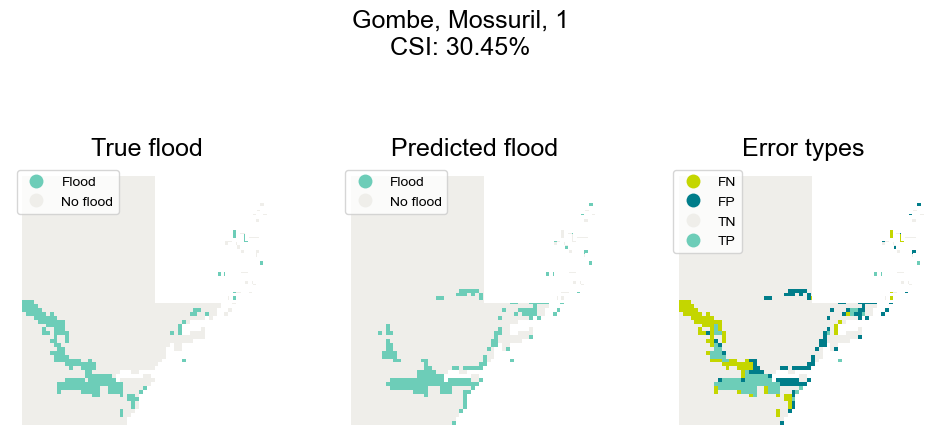

In [24]:
# choose which unseen event to plot
i = 0
to_plot = gdf_test_unseen[gdf_test_unseen.event == test_events[i]]

# colormap
cmap= ListedColormap([soge_colours['light turquoise'], soge_colours['beige']])
cm_categories = ListedColormap([soge_colours['yellowish green'], soge_colours['medium turquoise'],
                                soge_colours['beige'], soge_colours['light turquoise']])

# labels
labels = np.array(["No Flood", "Flood"])
len_lab = len(labels)

# plot
fig, axs = plt.subplots(1, 3, figsize=(12, 6))
to_plot.plot('floodfrac', ax=axs[0], categorical=True, cmap=cmap,
                      legend=True, legend_kwds={'loc': 'upper left'})
to_plot.plot('flood_pred', ax=axs[1], categorical=True, cmap=cmap,
                      legend=True, legend_kwds={'loc': 'upper left'})
to_plot.plot('error_type', categorical=True, cmap=cm_categories,
                      legend=True, legend_kwds={'loc': 'upper left'}, ax=axs[2])


fig.suptitle(f"{', '.join([x.capitalize() for x in test_events[i].split('_')])}\nCSI: {CSIs_test_unseen[i]:.2%}",
             fontsize=18);

axs[0].set_title('True flood', fontsize=18)
axs[1].set_title('Predicted flood', fontsize=18)
axs[2].set_title('Error types', fontsize=18)

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

# format output png and save
outpath = join(imdir, 'rf_spatial', f'unseen_region_{test_events[i]}.png')
fig.savefig(outpath, bbox_inches='tight', dpi=500)
outpath = join(imdir, 'rf_spatial', RUNNAME, f'unseen_region_{test_events[i]}.png')
fig.savefig(outpath, bbox_inches='tight', dpi=500)

## Log the results

In [25]:
logthisrun = True

In [26]:
if logthisrun:
    logger.info("NEW RUN")
    logger.info(f"Loading data with:\ntemporal={temporal},\nbinary={binary} with thresh. {floodthresh},\nstorm subset: {storm}")
    logger.info(f"Run with {nfeatures} features: {features}")
    logger.info(f"Number of unique images/subregions: {gdf_normalised['event'].nunique()}")
    logger.info(f"Notes: {notes}")

    logger.info(f"Zeros: {n0}")
    logger.info(f"Ones: {n1}")

    logger.info(f"Starting {K}-fold CV with seed={SEED}")
    logger.info(f"Running random forest with params:\n{best_params}")

    logger.info(f"Mean CSI: {np.mean(CSIs):.2%}")
    logger.info(f"CSI Std. Dev.: {np.std(CSIs):.2%}")
    logger.info(f"CSI on test set: {CSI_test_seen:.2%}")
    logger.info(f"CSI on unseen subregion {[*test_events]}: {CSI_test_unseen:.2%}")
    logger.info(f"Results for {[test_event.replace('_', ' ') for test_event in test_events]} in {outpath}")

    logger.info(f"Impurity-based importance: mean rankings:\n{mean_rankings}")
    if run_pis:
        logger.info(f"Permutation-based importance: mean rankings:\n{mean_pis}")

    logger.info("END OF RUN\n\n\n")
    
    
    # add to the metrics csv
    metrics_dict = {
        'date': runtime.strftime("%Y-%m-%d %Hh%Mm"),
        'runname': RUNNAME,
        'notes': [notes],
        'temporal': 'True' if temporal else 'False',
        'binary': floodthresh if binary else 'False',
        'nevents': gdf_normalised['event'].nunique(),
        'nfeatures': nfeatures,
        'features': [[*features]],
        'nzeros': n0,
        'nones': n1,
        'folds': K,
        'SEED': SEED,
        'best_params': [best_params],
        'mean train CSI': np.mean(CSIs),
        'std train CSIs': np.std(CSIs),
        'test CSI (seen)': CSI_test_seen,
        'test CSI (unseen)': CSI_test_unseen,
        'impurity-based rankings': [[*mean_rankings.index]],
        'impurity-based scores': [mean_rankings.values],
        'perm-based rankings': [[*mean_pis.index]] if run_pis else "not done",
        'perm-based scores': [mean_pis.values],
        'results folder': outpath
    }

    all_metrics = pd.read_csv(join(wd, 'images', 'rf_spatial', 'metrics.csv')).astype(str)
    metrics_df = pd.DataFrame.from_dict(metrics_dict, orient='columns', dtype='object').astype(str)
    new_metrics = all_metrics.append(metrics_df)
    new_metrics = new_metrics.drop_duplicates()
    new_metrics.to_csv(join(wd, 'images', 'rf_spatial', 'metrics.csv'), index=False)

In [27]:
new_metrics[['runname', 'mean train CSI', 'std train CSIs', 'test CSI (seen)',
       'test CSI (unseen)']]

,runname,mean train CSI,std train CSIs,test CSI (seen),test CSI (unseen)
0,thresh 0.0,0.8784975971985883,0.0032572083187456,0.8633268482490273,0.3847874720357941
1,thresh 0.5,0.8781328879785454,0.002977378219009,0.8644314868804664,0.397752808988764
2,Remove water cells,0.826705771495536,0.0054892480835855,0.8263473053892215,0.2608695652173913
3,intermediate wet-dry features,0.8222566408945449,0.0065548973570173,0.8237243207422134,0.2489082969432314
4,intermediate wet-dry features with rai hinunangan,0.8237428452922126,0.0094660482739594,0.8326822916666666,0.0894941634241245
5,intermediate wet-dry features with roanu bargu...,0.8100833843633695,0.0097206055029723,0.8081805359661495,0.8889645776566758
6,MENABE_AND_CUBA,0.8388113593109725,0.0094772996019447,0.8579838116261957,0.8816768086544963
7,make unseen test set bigger,0.8336171897593619,0.0056643734966362,0.8406113537117904,0.8382526564344747
8,added Megi,0.8398397835199081,0.0059875011426351,0.8404864091559371,0.8328479906814211
9,Different unseen test set,0.857270747113336,0.0031357819763575,0.8663563829787234,0.3946188340807174


In [ ]:
! say done

# Hyperparameter Tuning (Optional)
## 1. Random CV
From [this tutorial](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74).

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# set up random grid search
randomcv = False

# look at base case
SEED = 1
rf = RandomForestClassifier(random_state=SEED)

# train-test split
X, y = gdf_normalised[features], gdf_normalised['flood']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=SEED)

if randomcv:
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    max_features = ['auto', 'sqrt']
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2, 4]
    bootstrap = [True, False]


    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    pprint(random_grid)
    
    rf = RandomForestClassifier()
    rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100,
                                   cv=3, scoring=csi_scorer, verbose=2, random_state=42, n_jobs=-1)

    rf_random.fit(X_train, y_train)
    print(rf_random.best_params_)
    
    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)
    grid_search.best_params_

    np.save('best_params_rf.npy', grid_search.best_params_) 
    
    
    base_model = RandomForestClassifier(random_state=SEED)
    base_model.fit(X_train, y_train)
    base_csi = evaluate(base_model, X_test, y_test)

    best_random = grid_search.best_estimator_
    random_csi = evaluate(best_random, X_test, y_test)

    print('Improvement of {:0.2f}%.'.format( 100 * (random_csi - base_csi) / base_csi))

    !say done

## 2. Grid Search

In [ ]:
gridsearch = False

if gridsearch:
    from sklearn.model_selection import GridSearchCV
    # Create the parameter grid based on the results of random search 
    param_grid = {
        'bootstrap': [False],
        'max_depth': [40, 45, 50, 55, 60],
        'max_features': ['auto'],
        'min_samples_leaf': [1, 2, 3],
        'min_samples_split': [1, 2, 3],
        'n_estimators': [500, 1000, 1500]
    }

    # Create a based model
    rf = RandomForestClassifier(random_state=SEED)
    # Instantiate the grid search model
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring=csi_scorer, 
                              cv=3, n_jobs=-1, verbose=2)
    
    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)
    grid_search.best_params_

    np.save('best_params_rf.npy', grid_search.best_params_) 